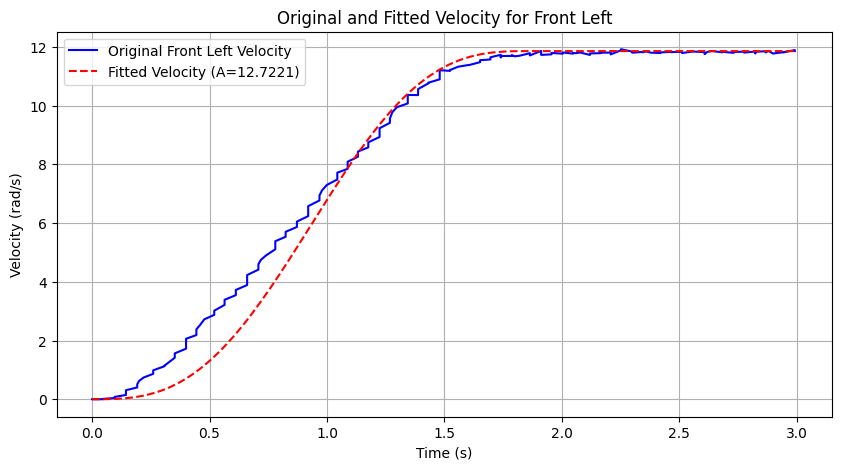

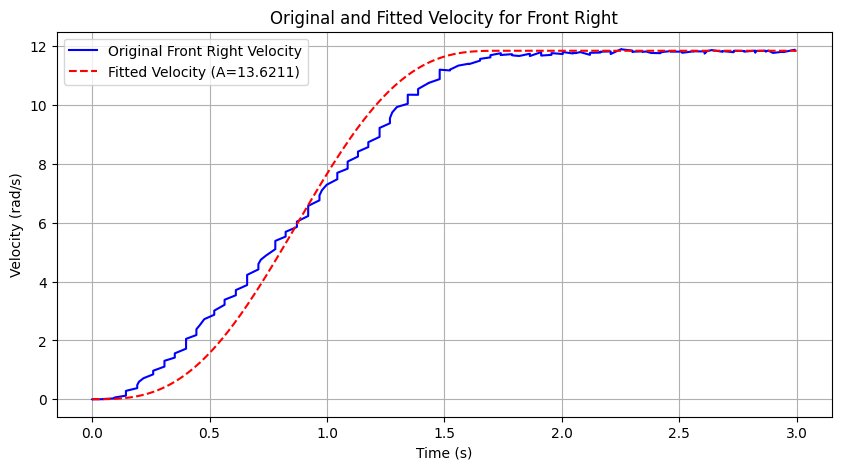

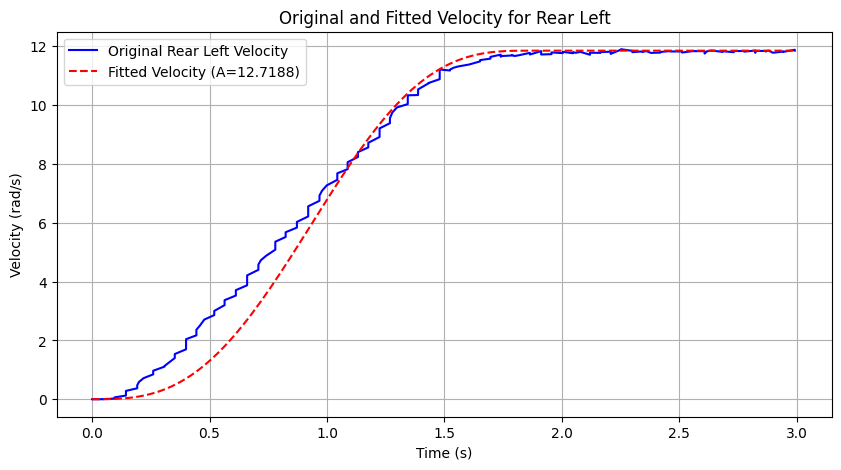

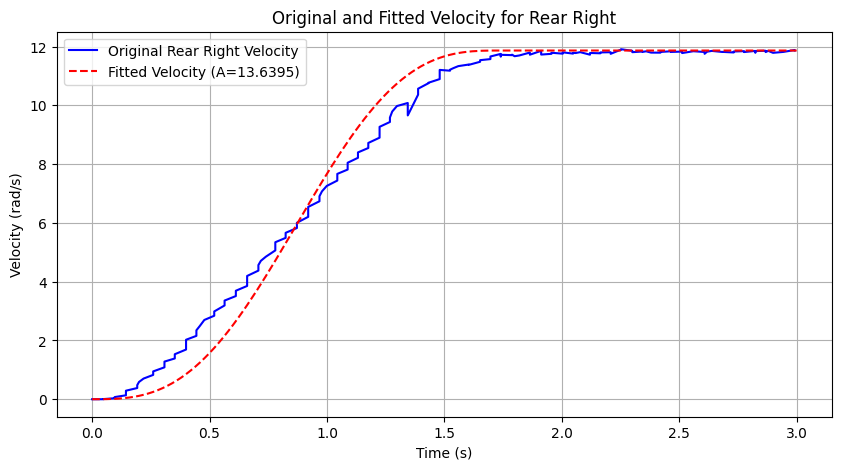

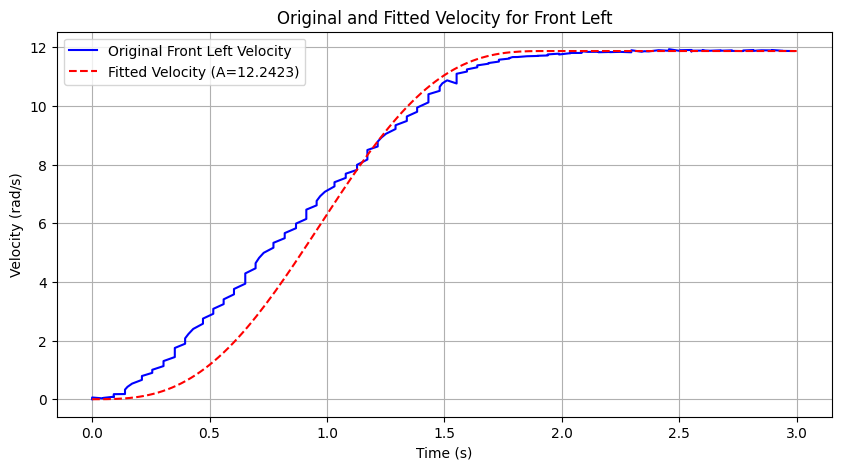

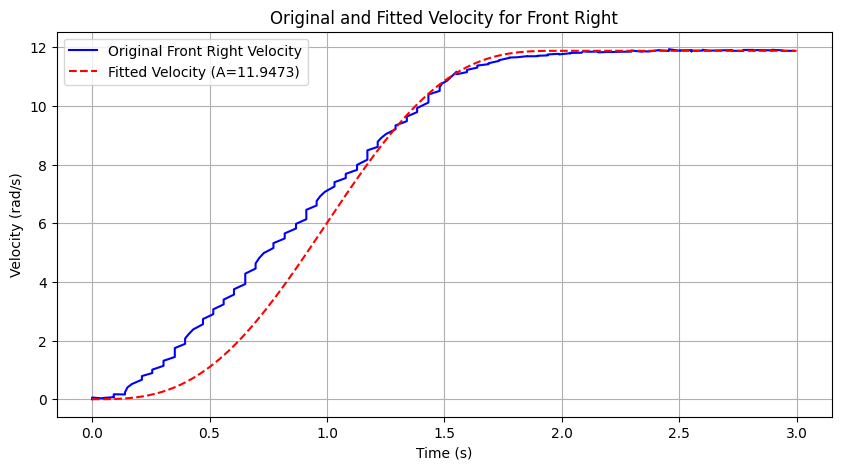

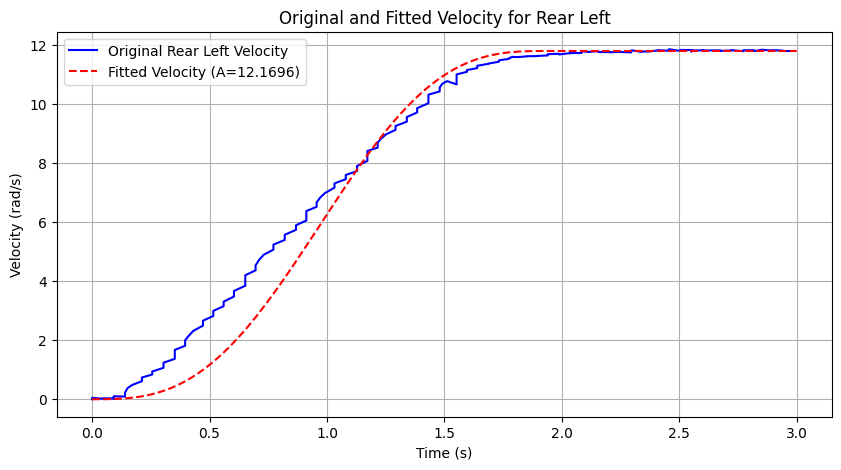

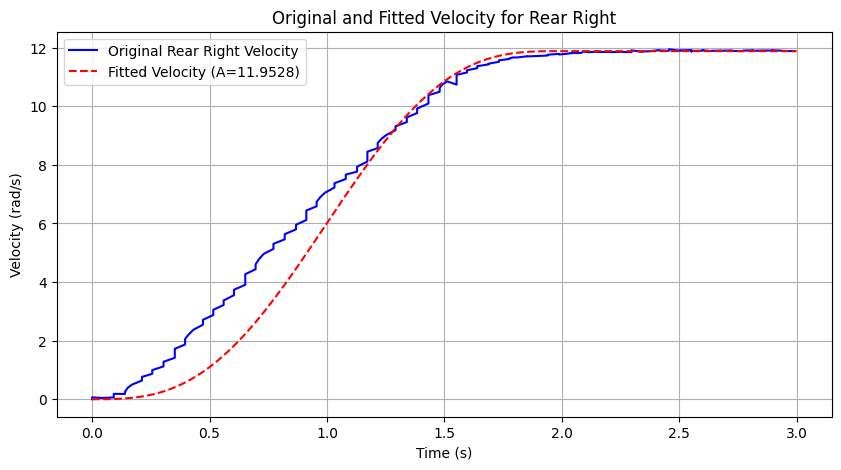

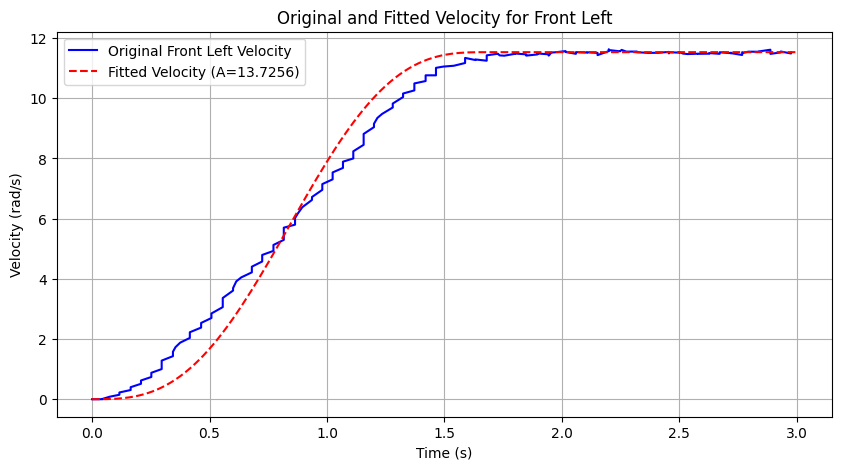

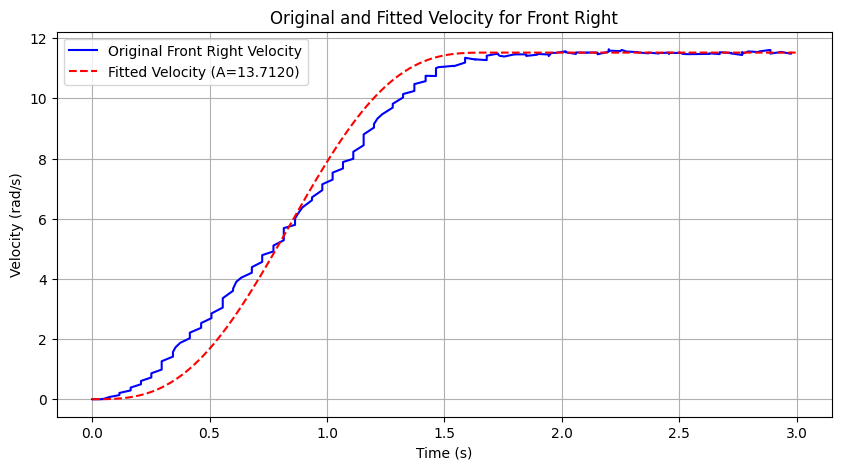

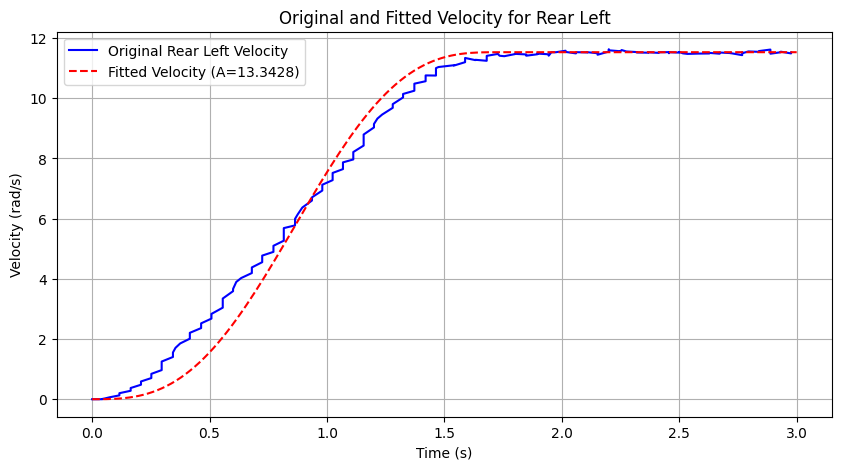

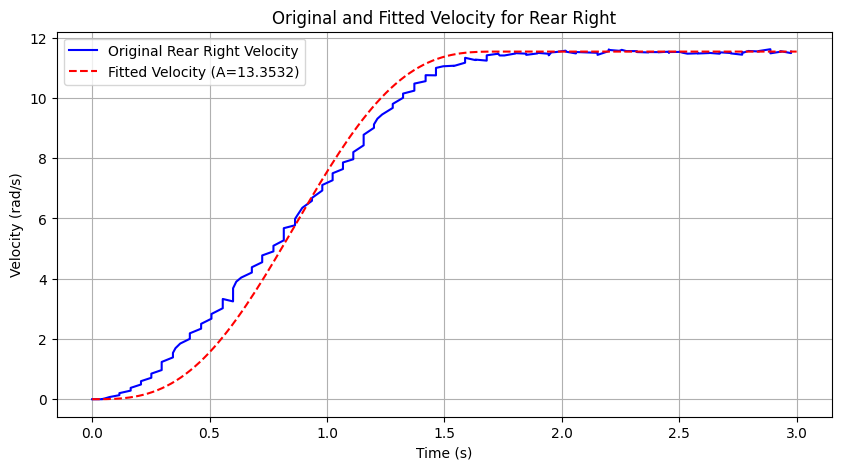

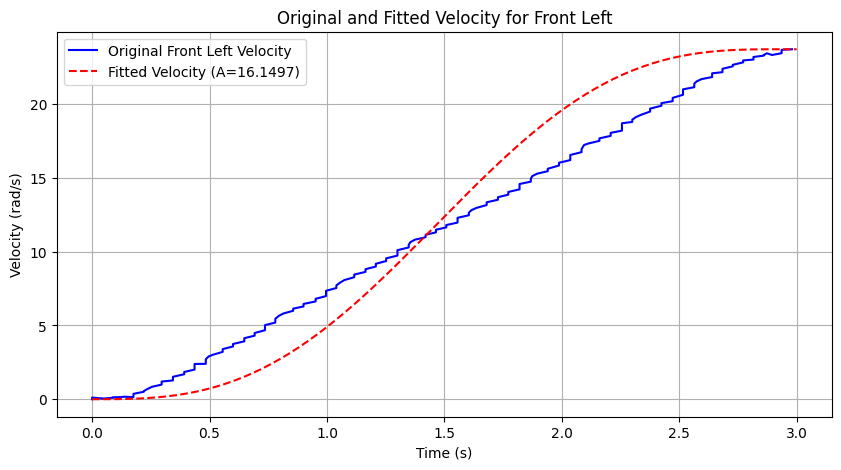

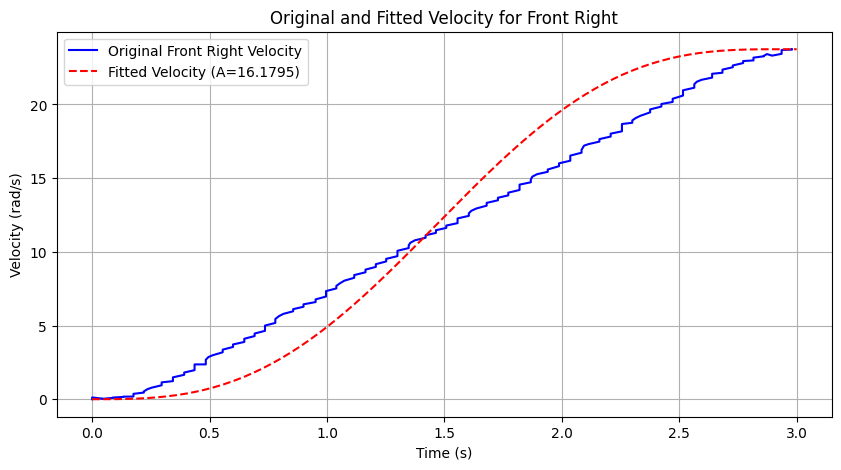

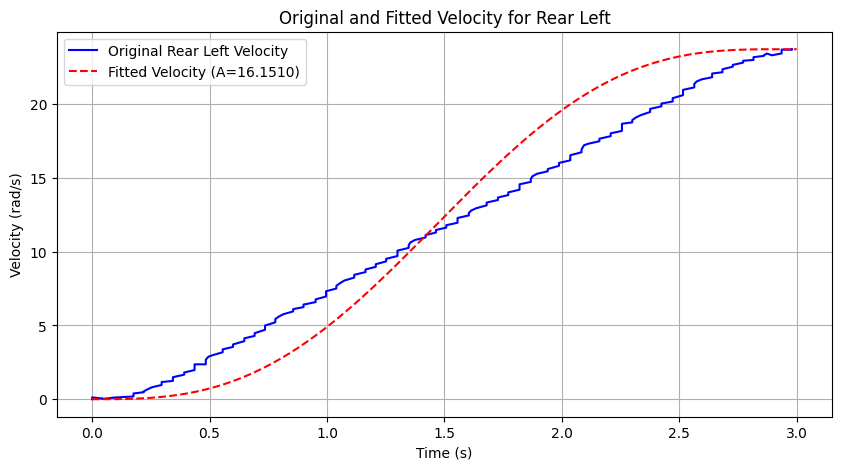

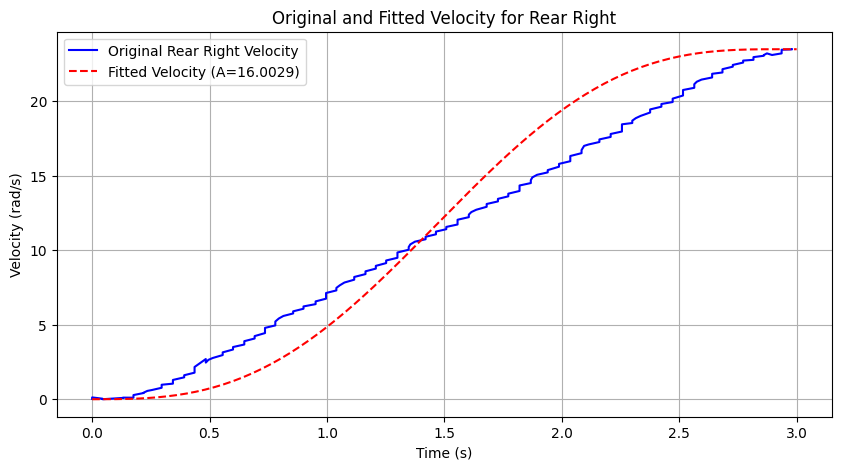

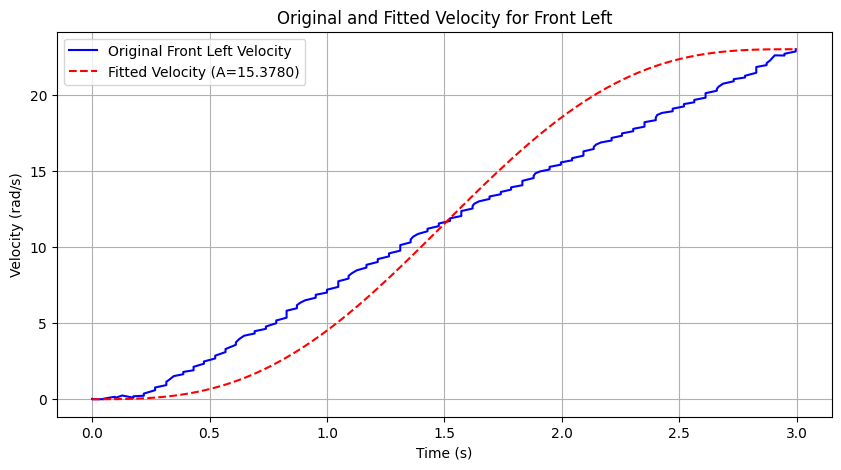

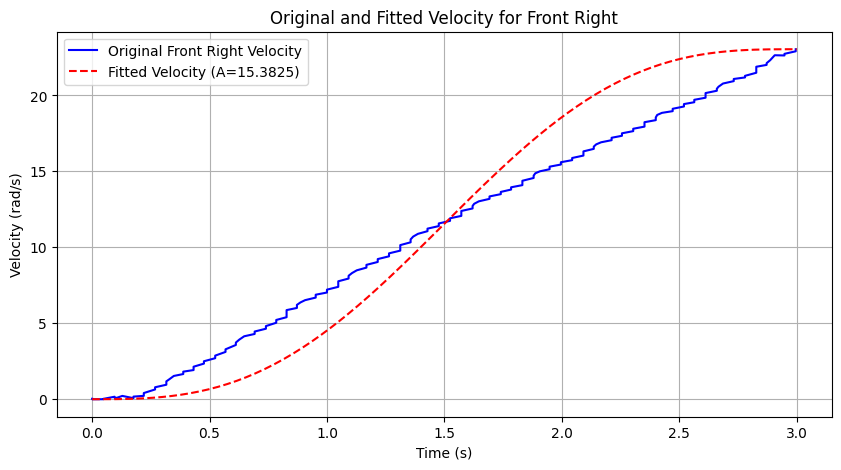

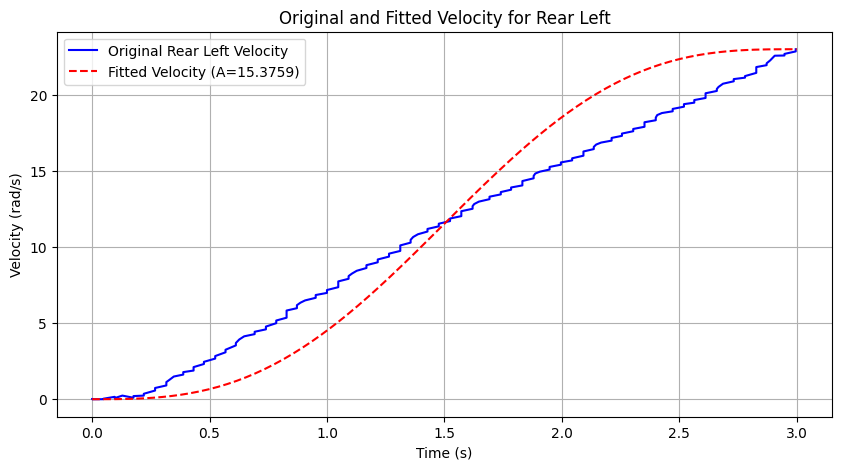

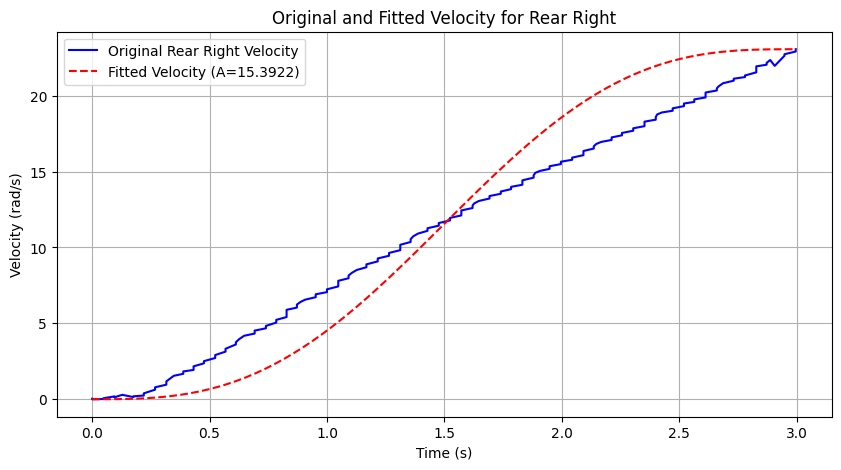

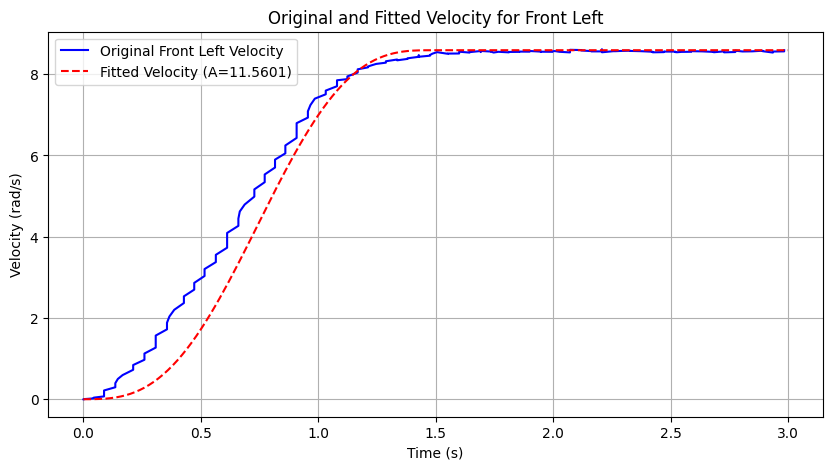

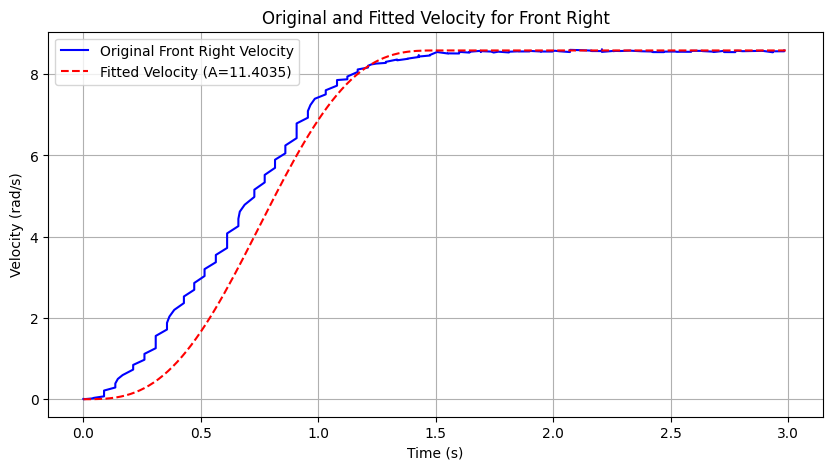

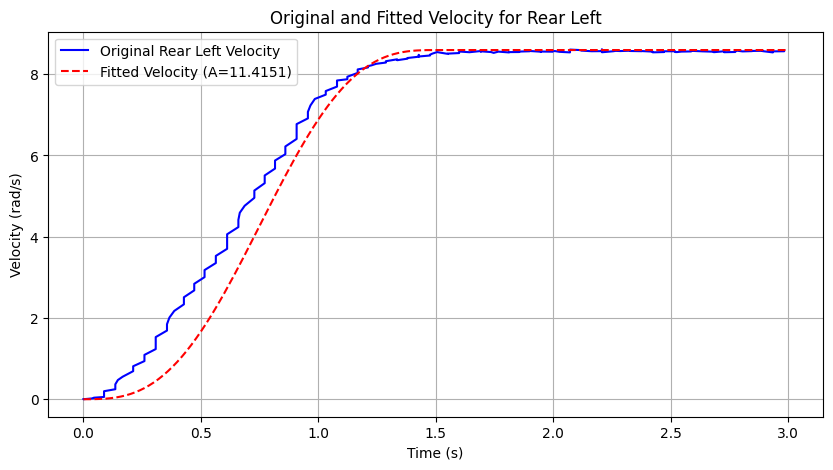

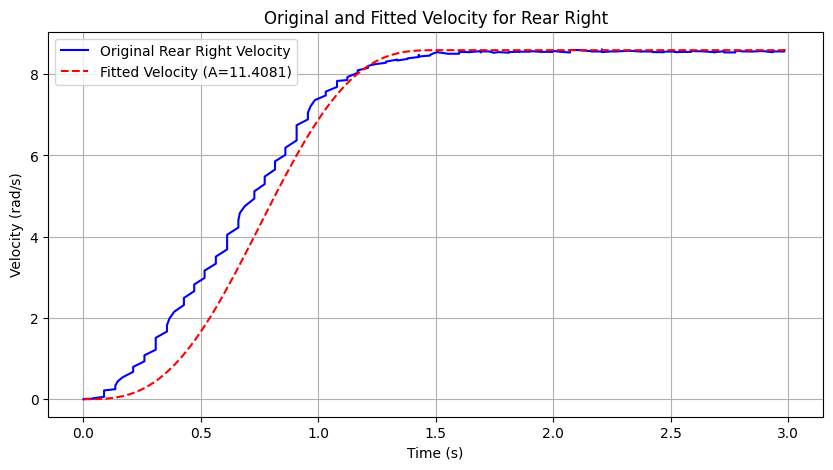

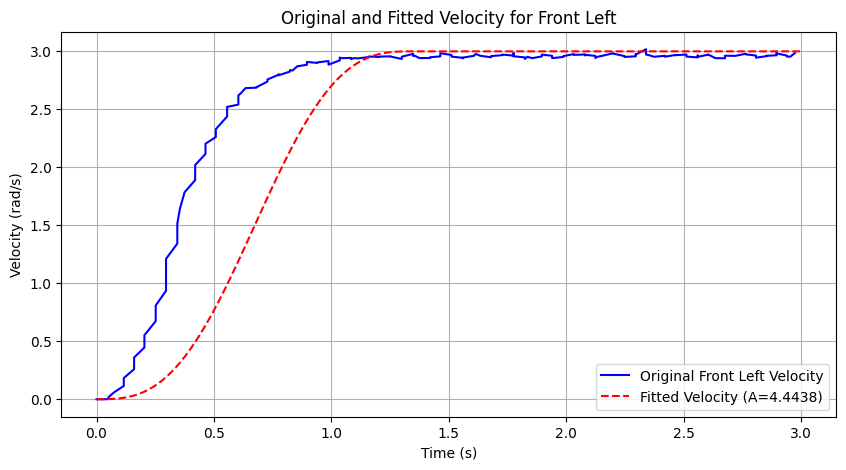

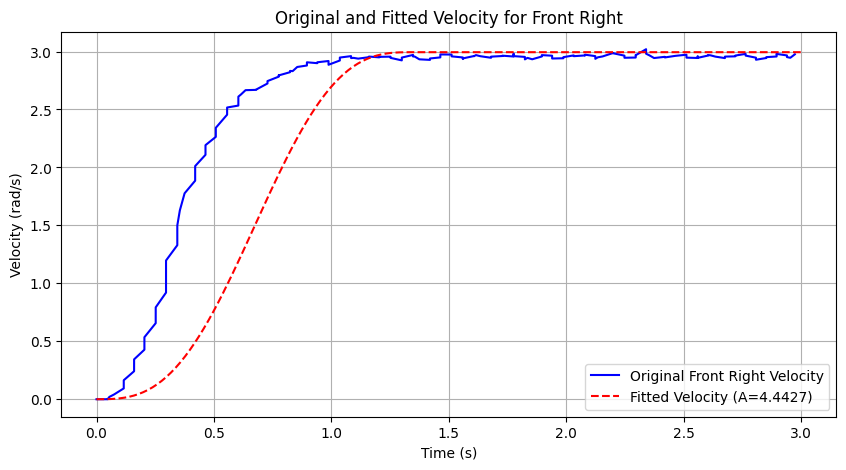

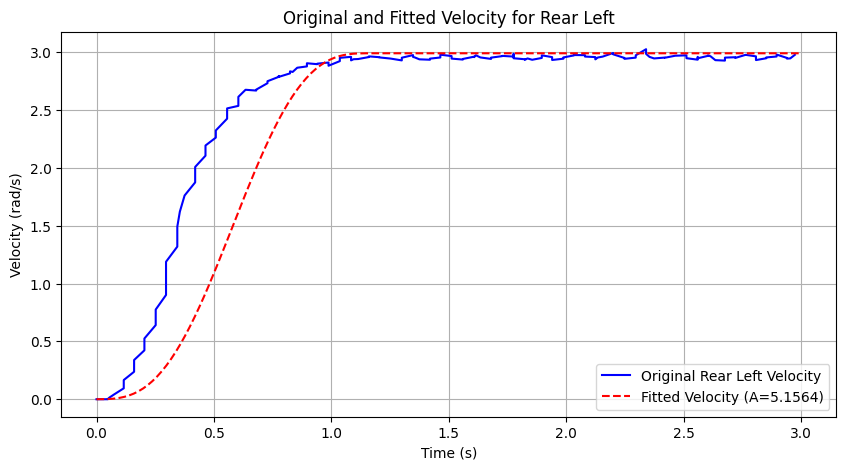

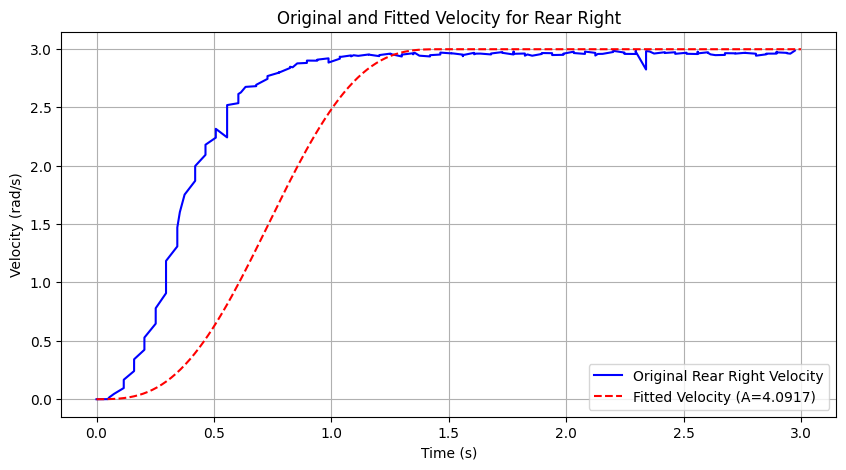

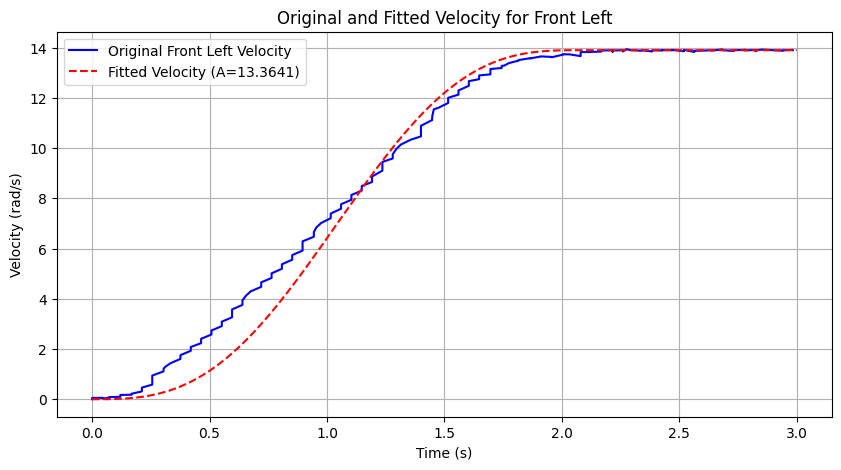

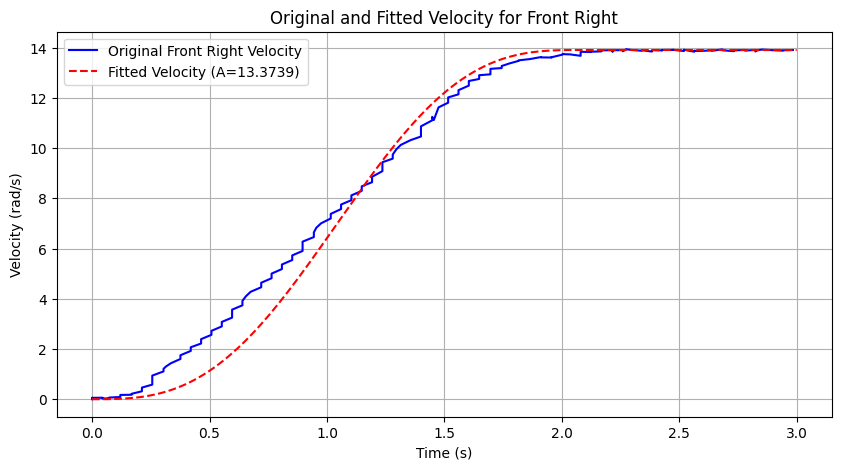

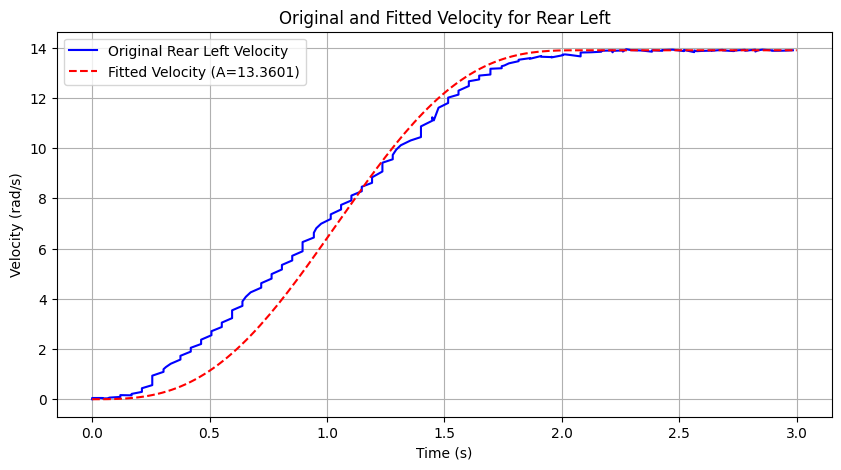

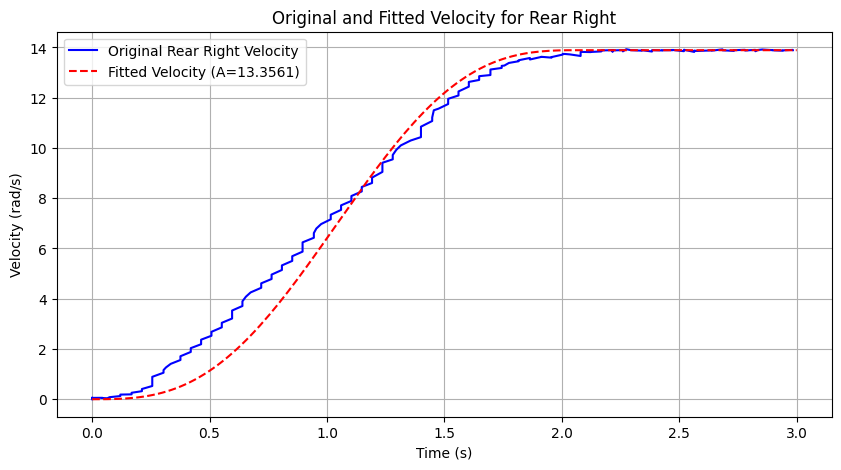

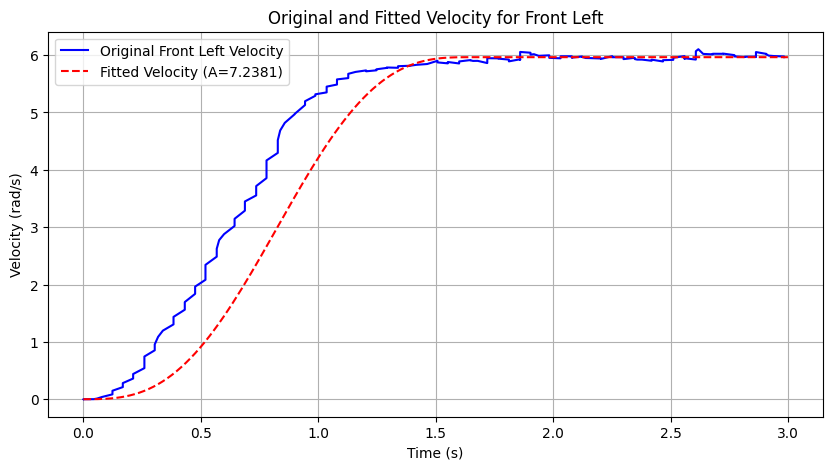

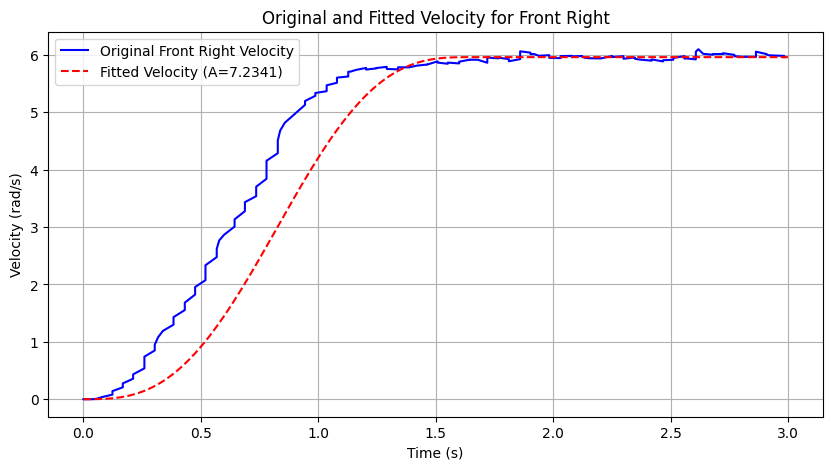

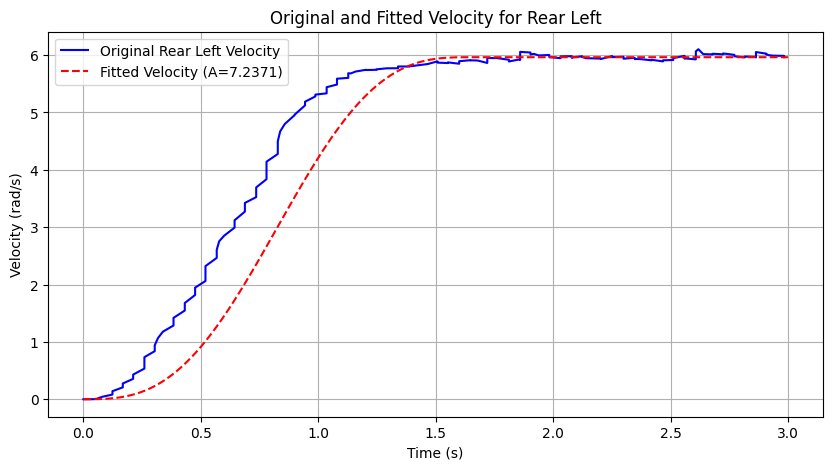

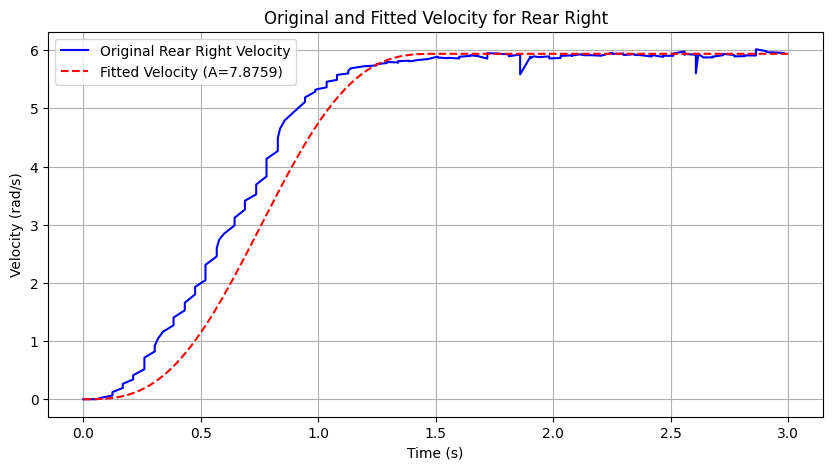

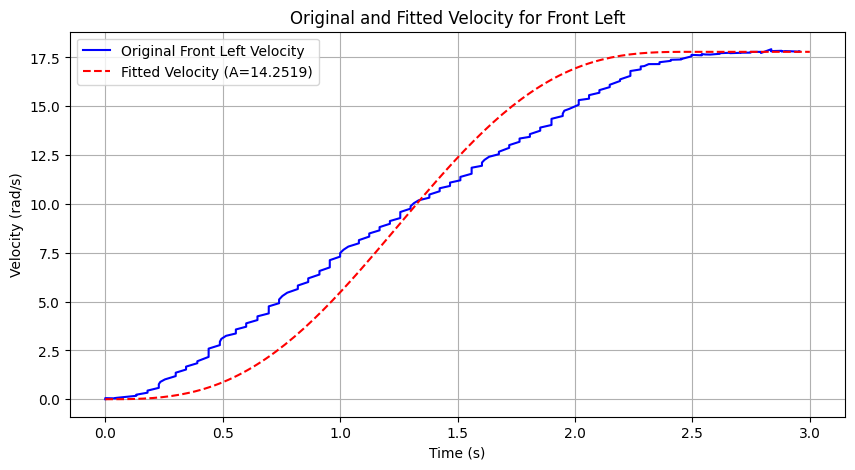

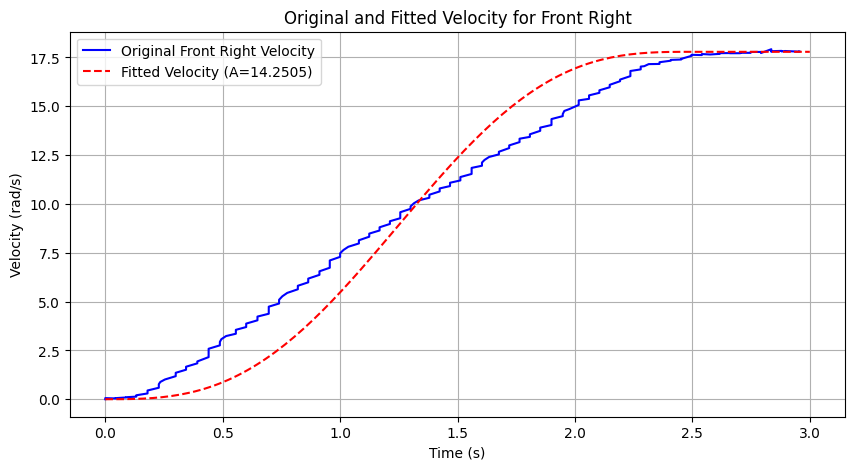

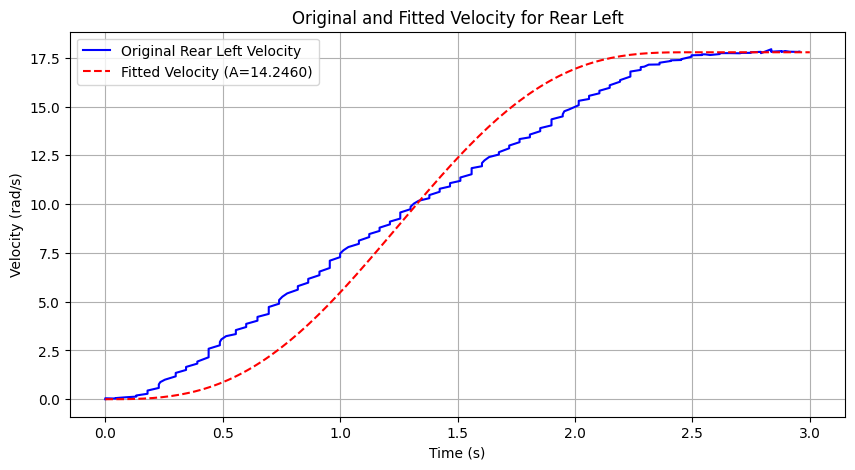

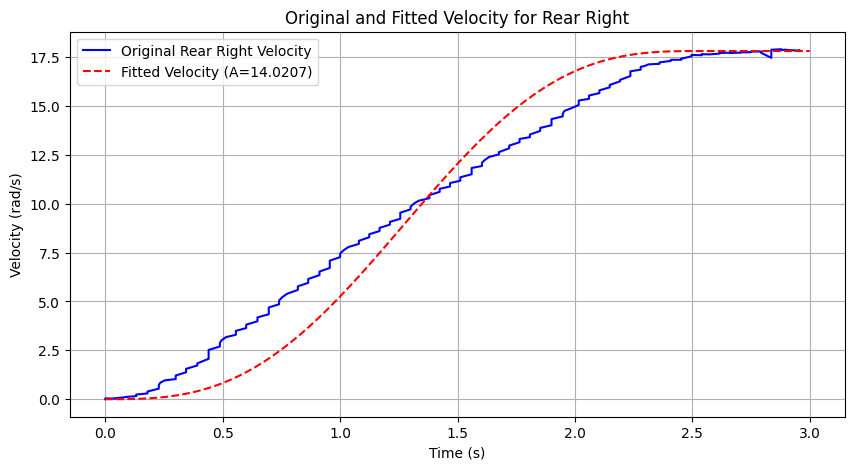

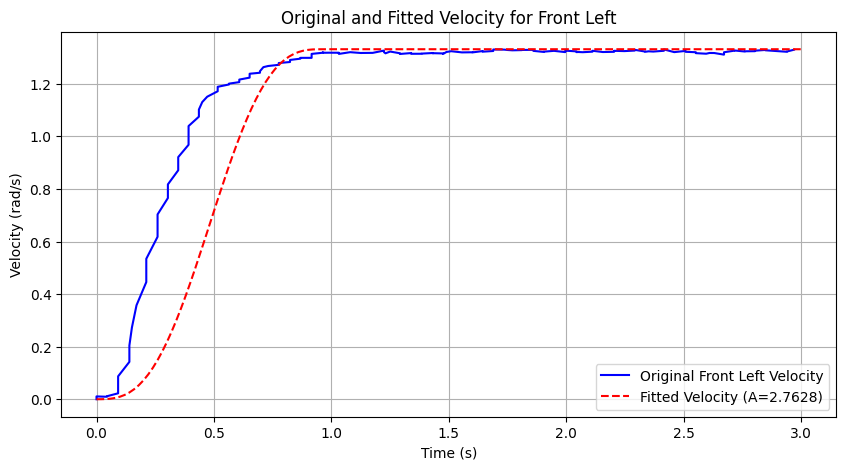

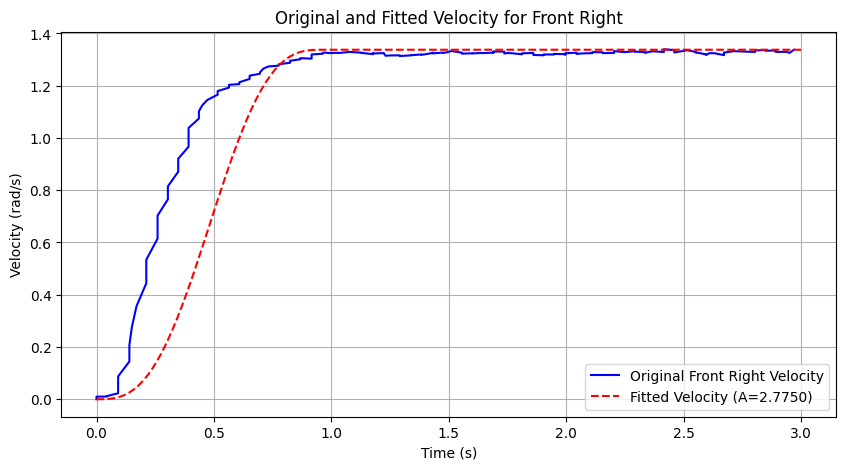

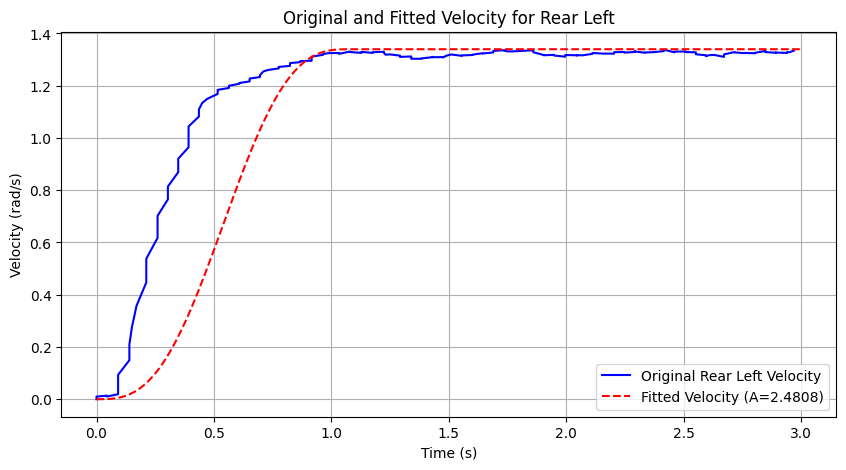

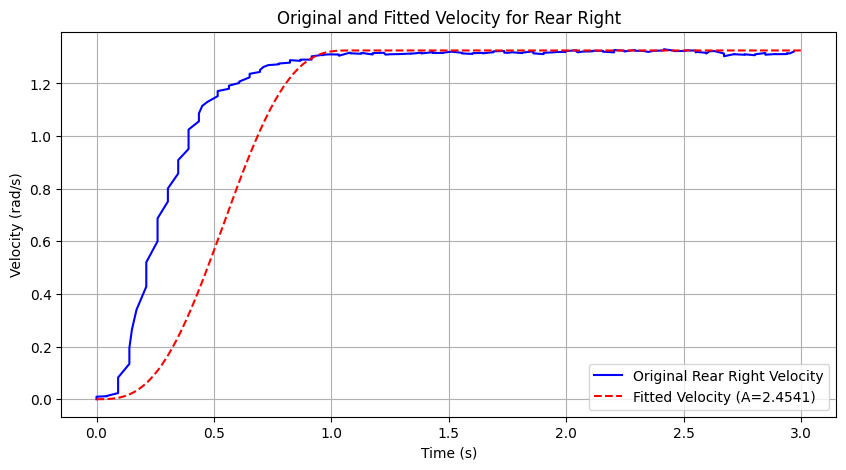

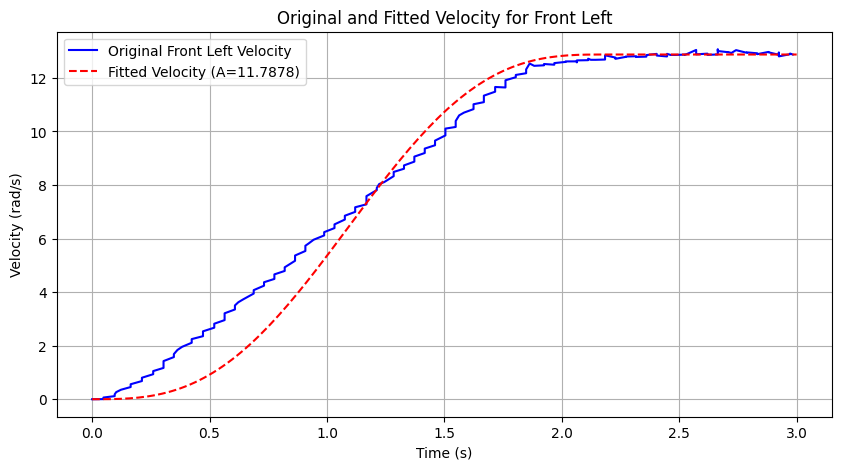

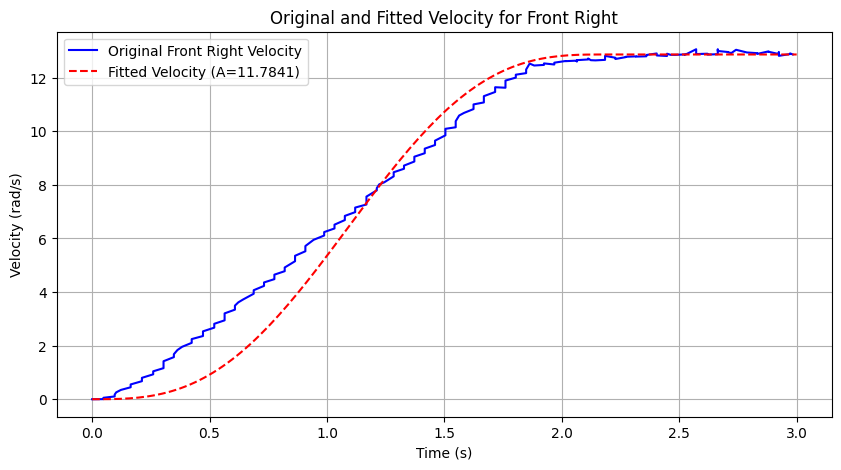

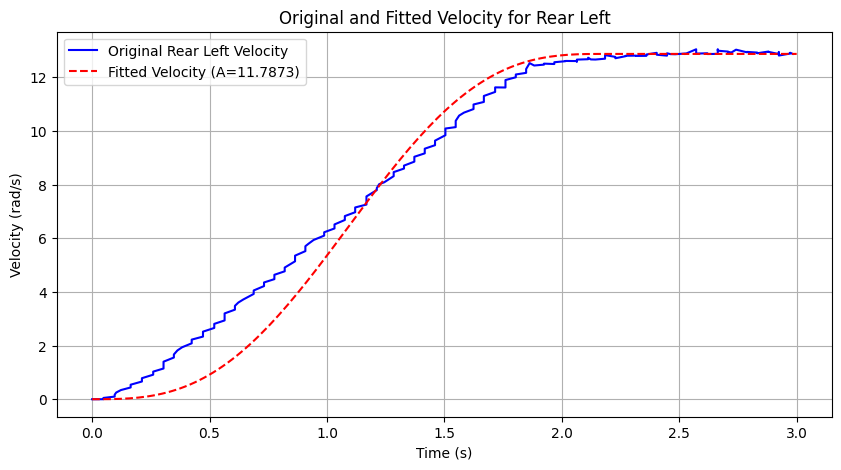

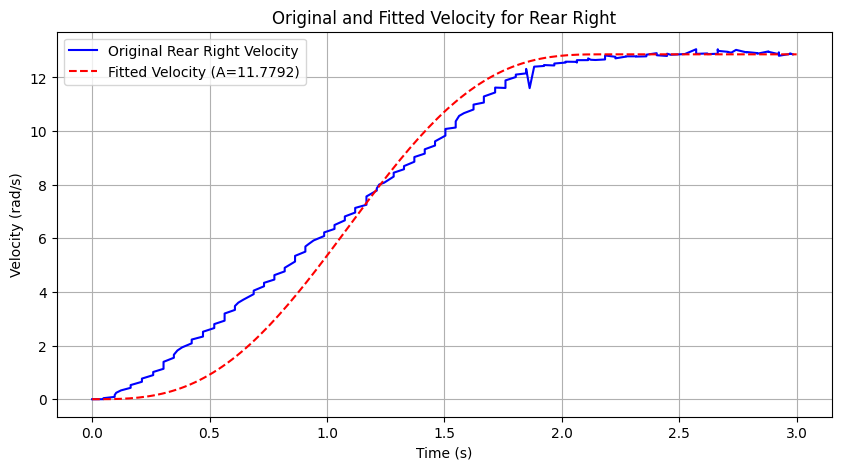

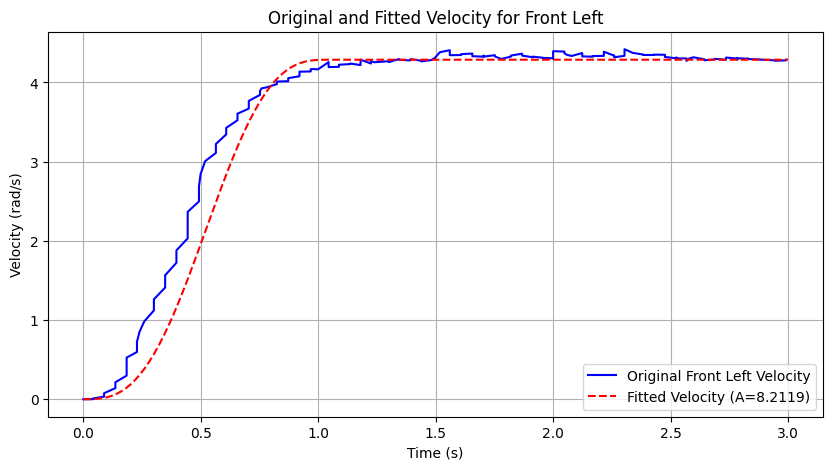

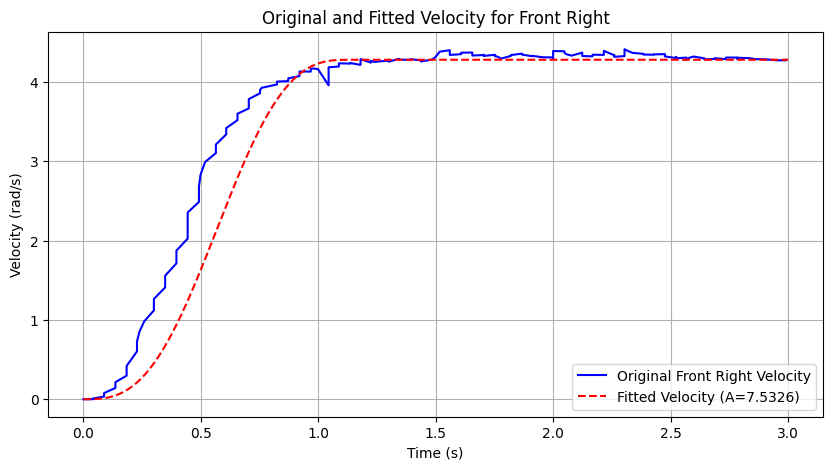

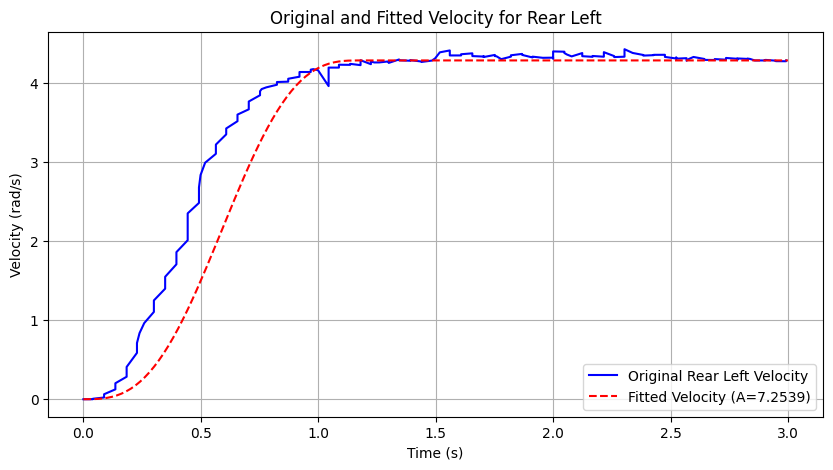

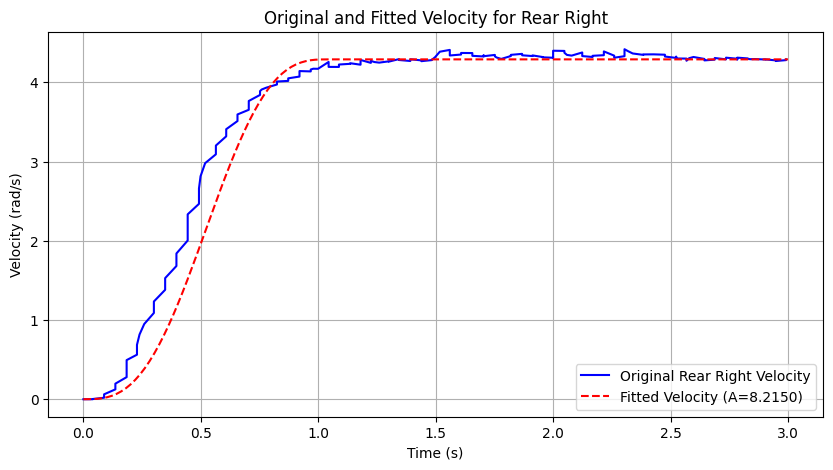

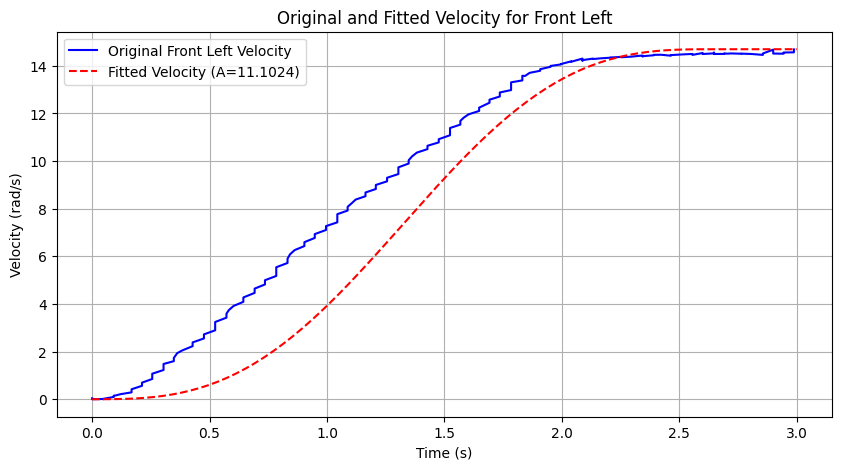

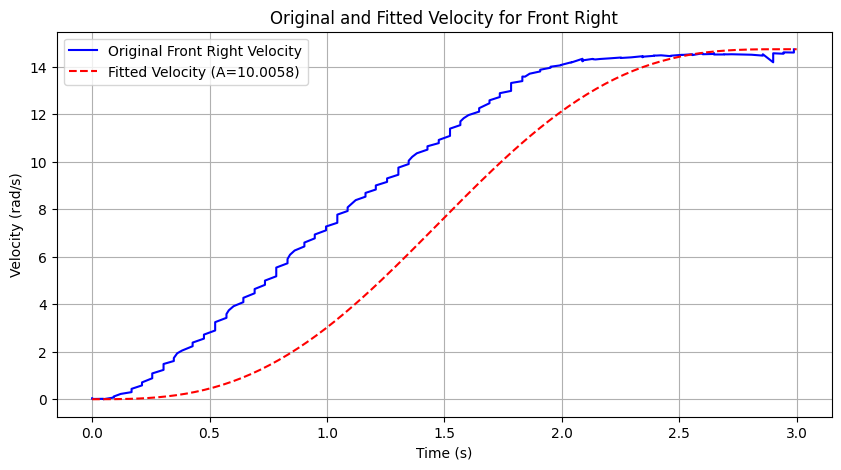

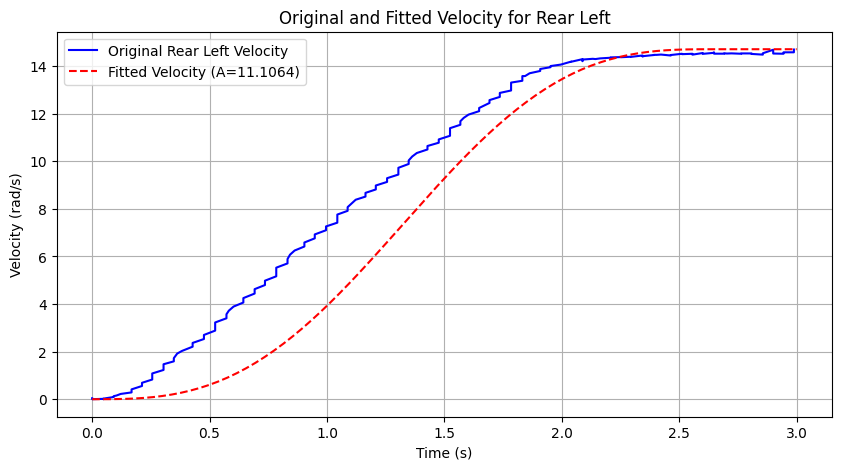

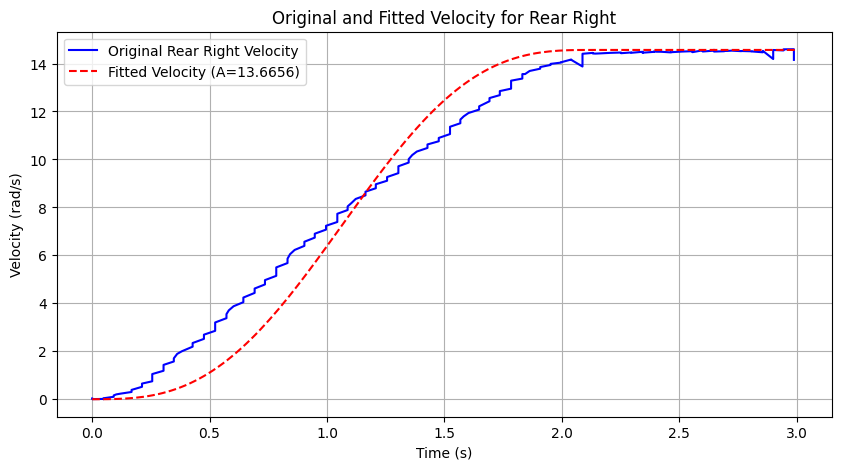

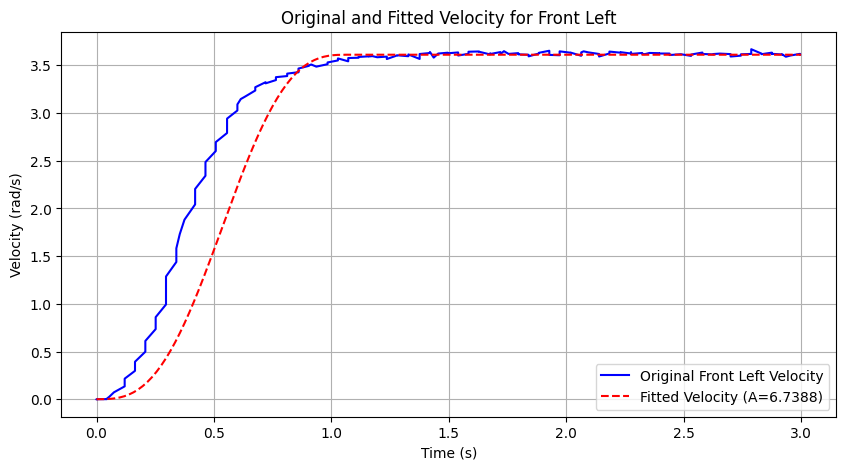

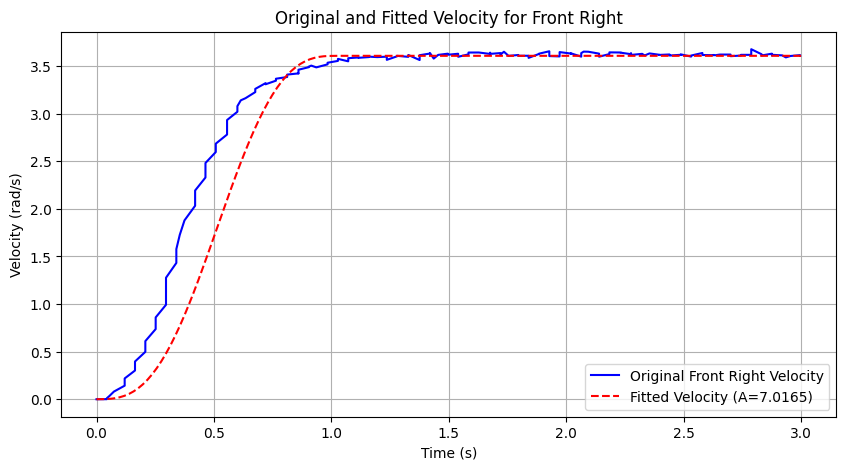

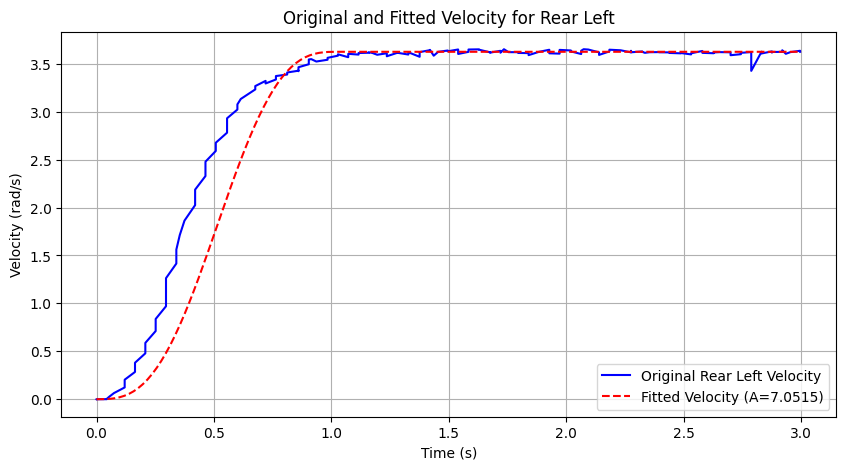

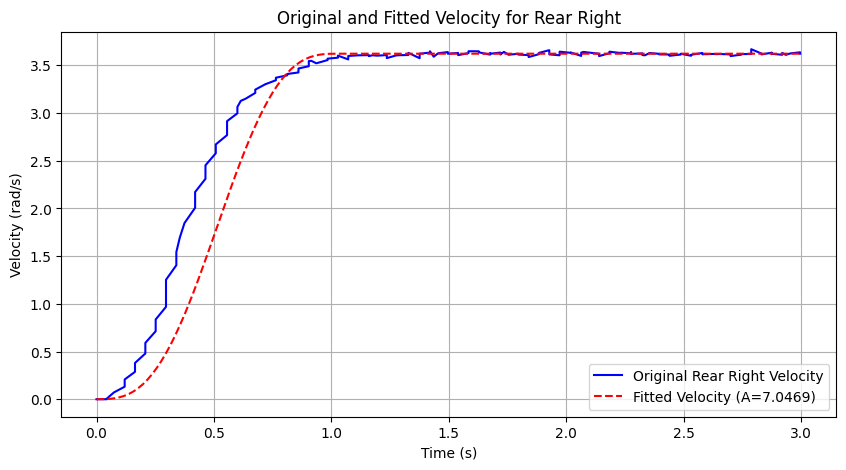

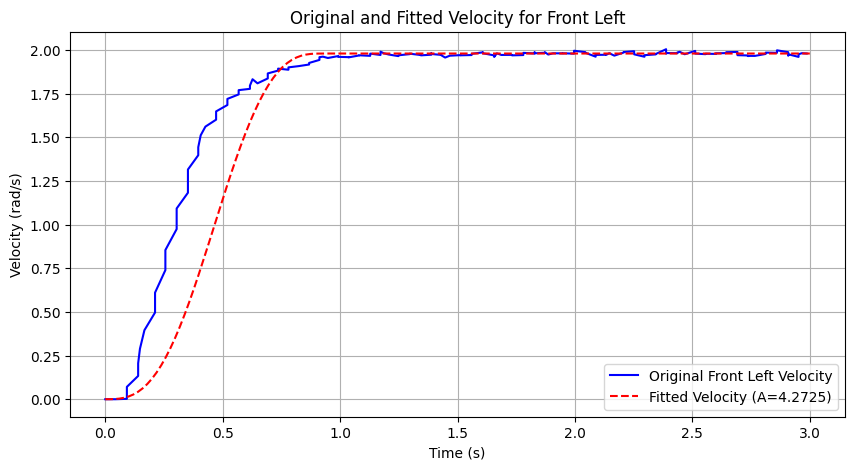

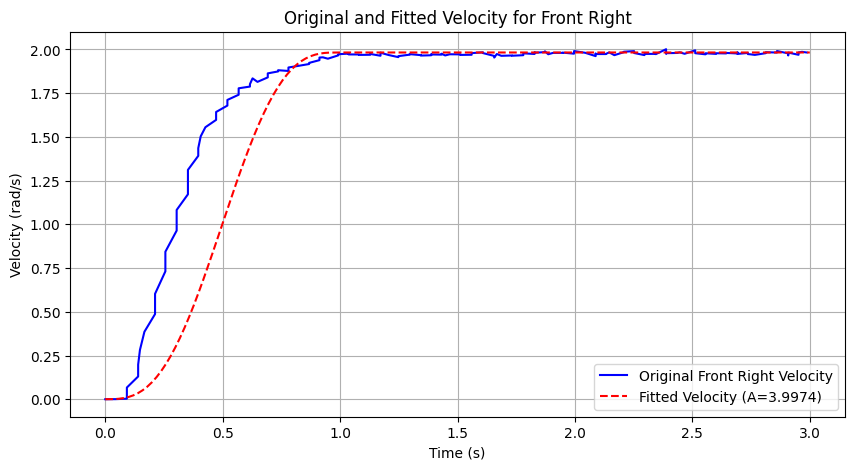

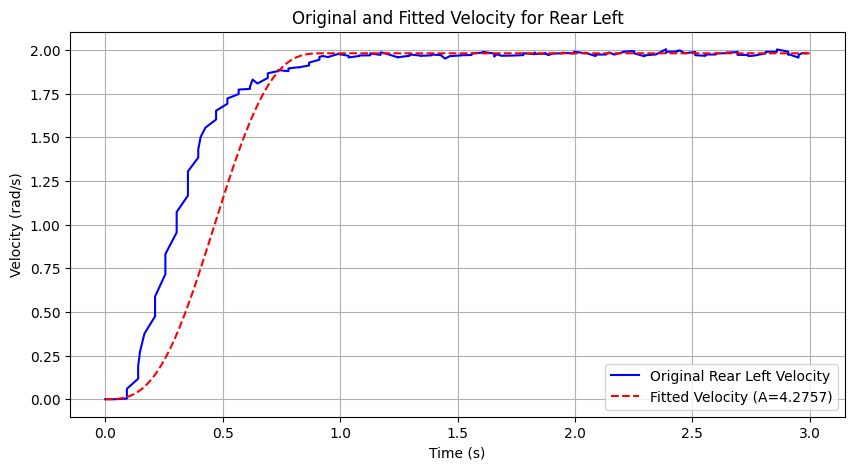

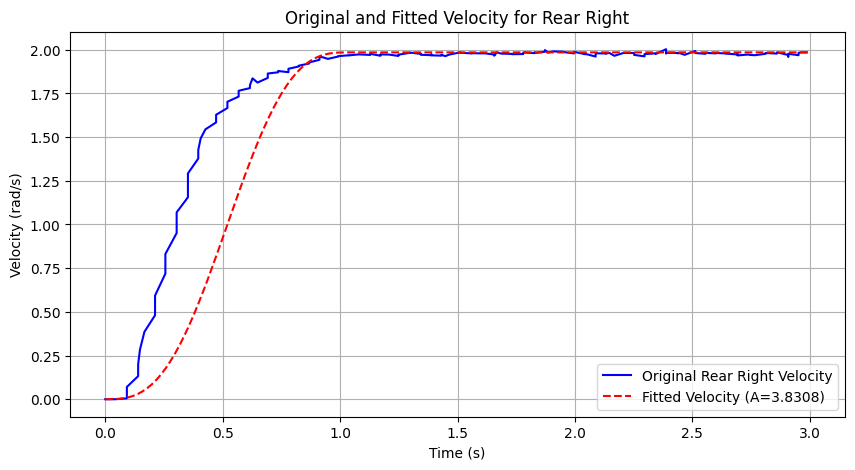

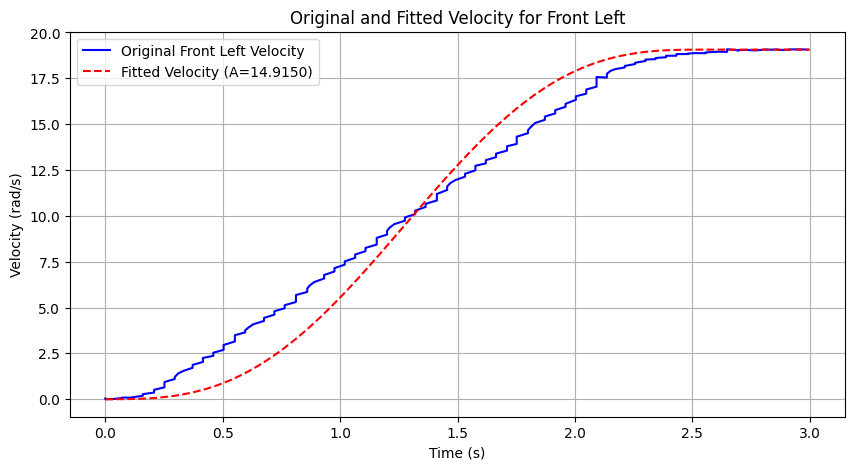

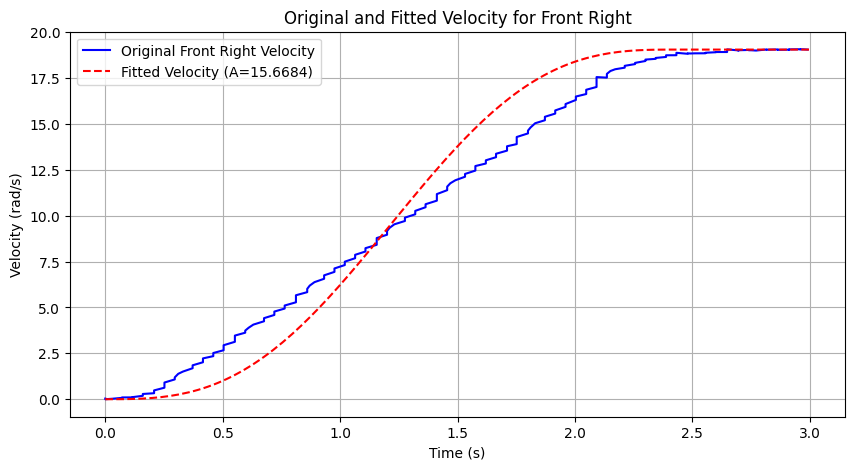

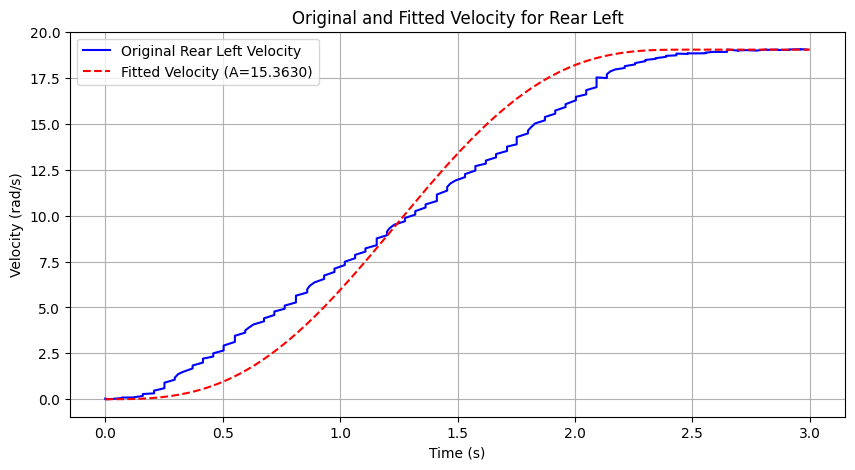

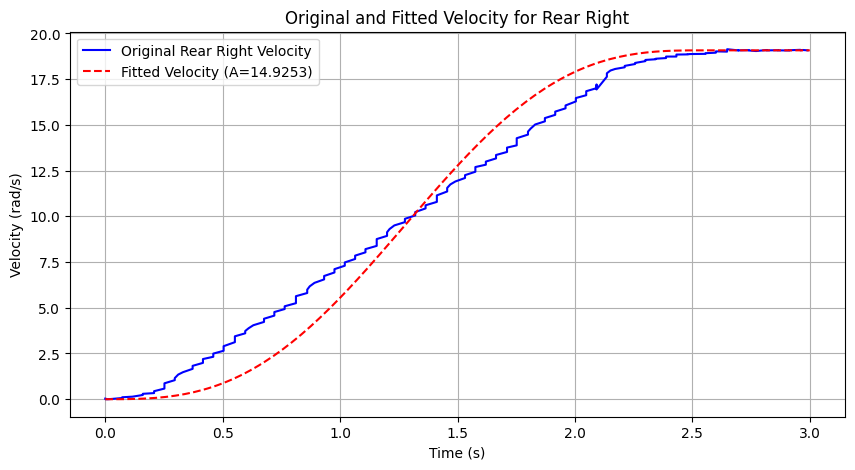

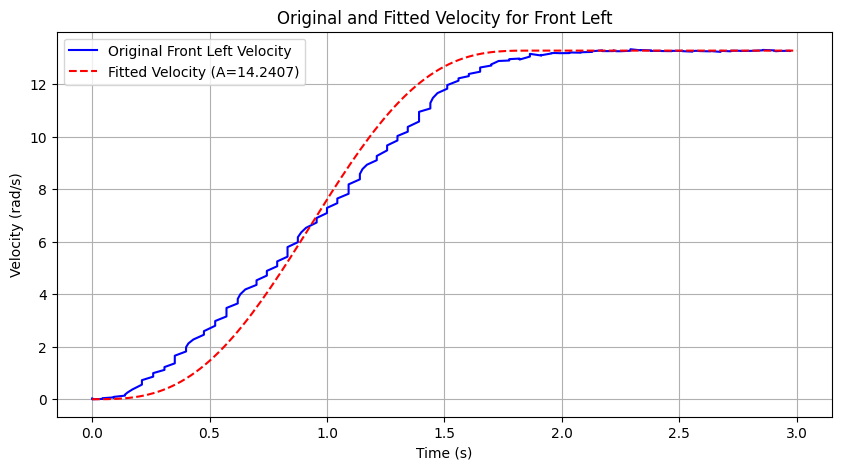

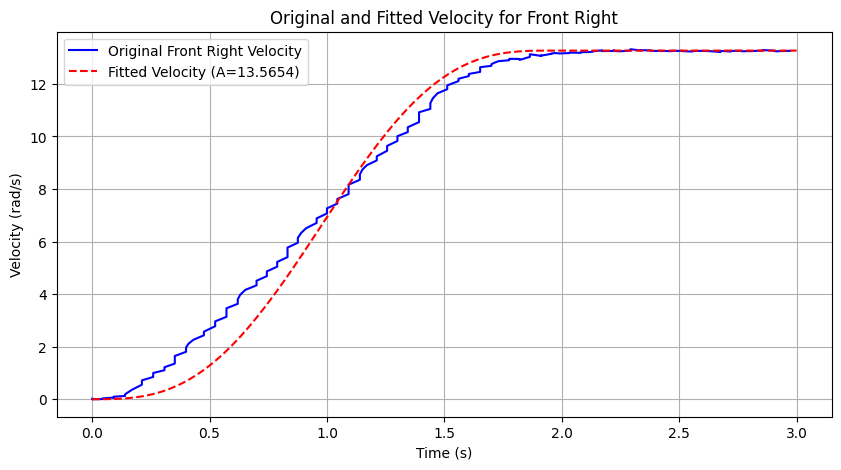

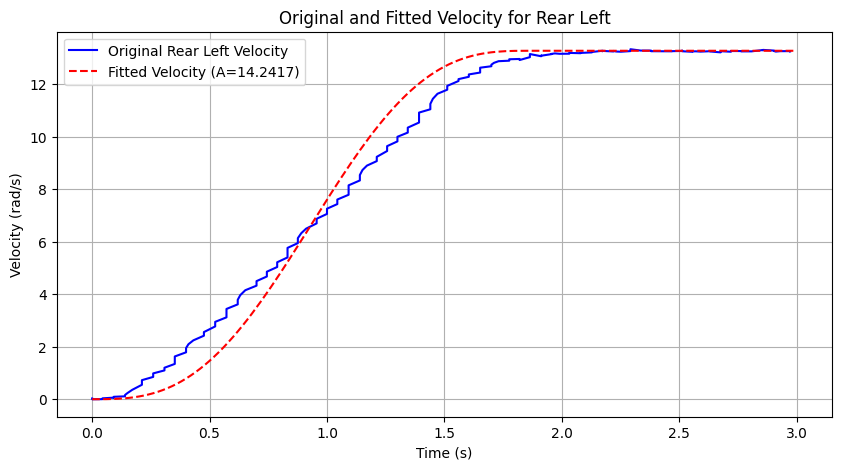

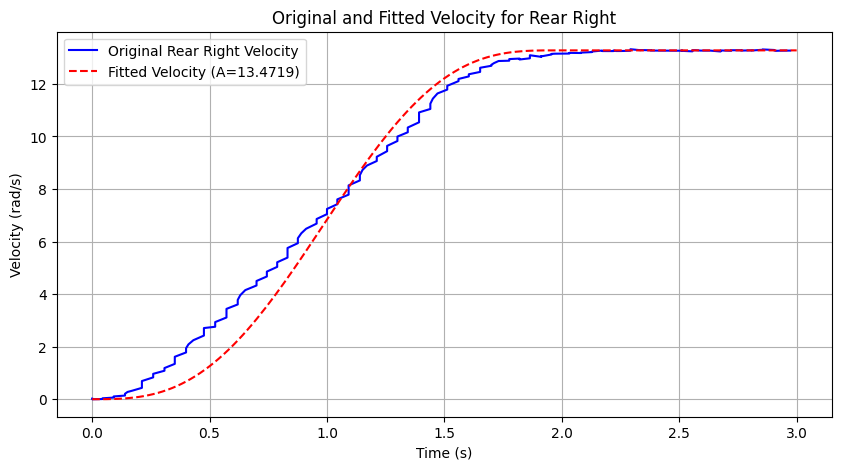

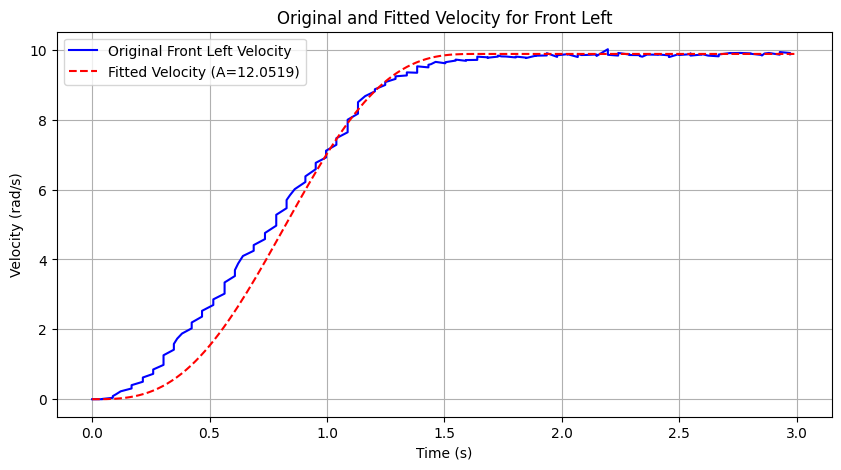

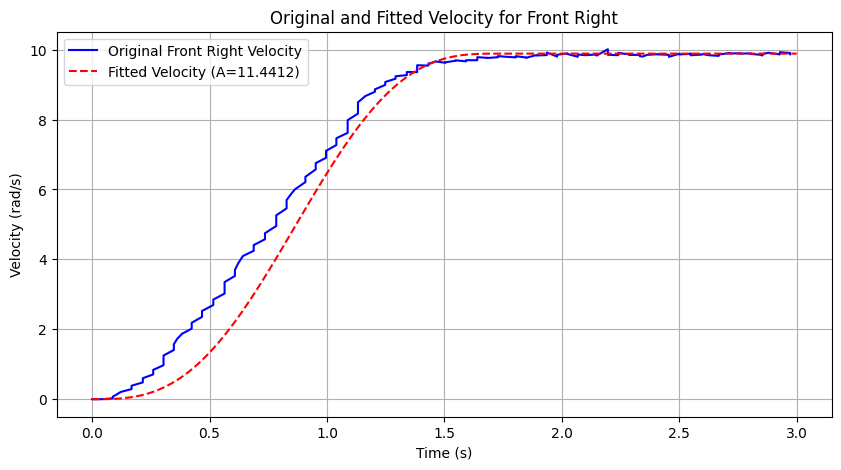

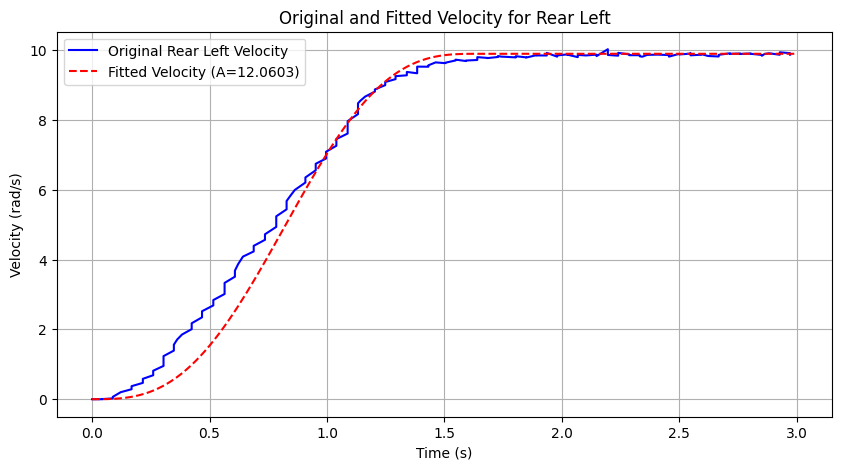

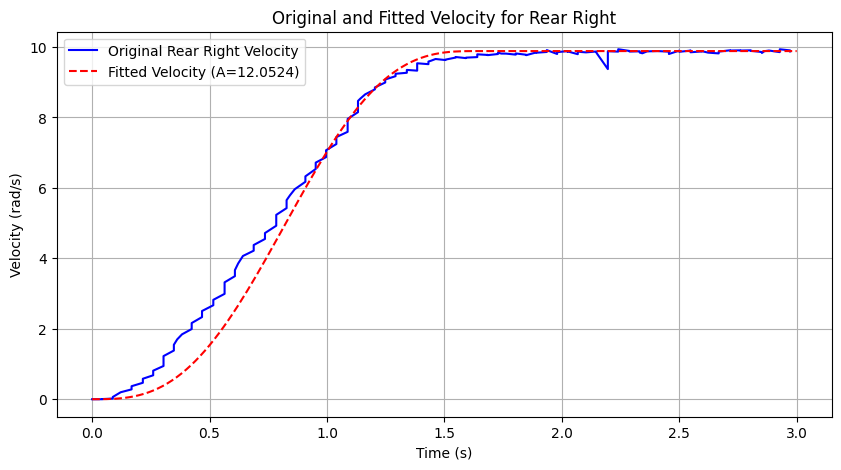

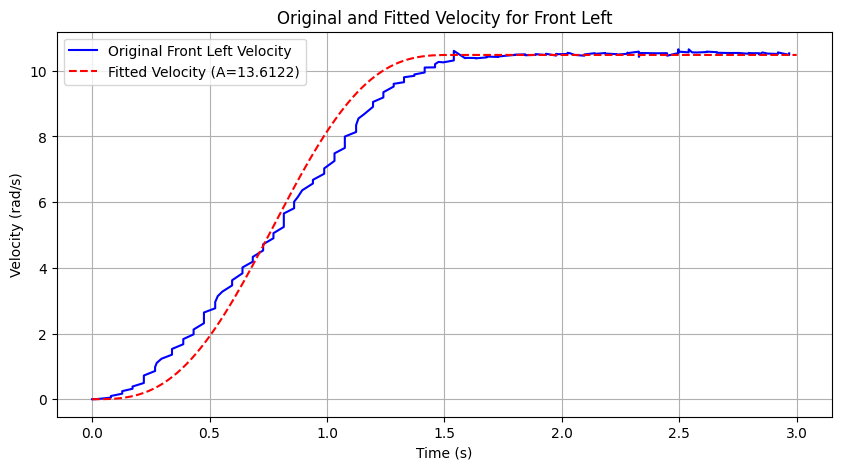

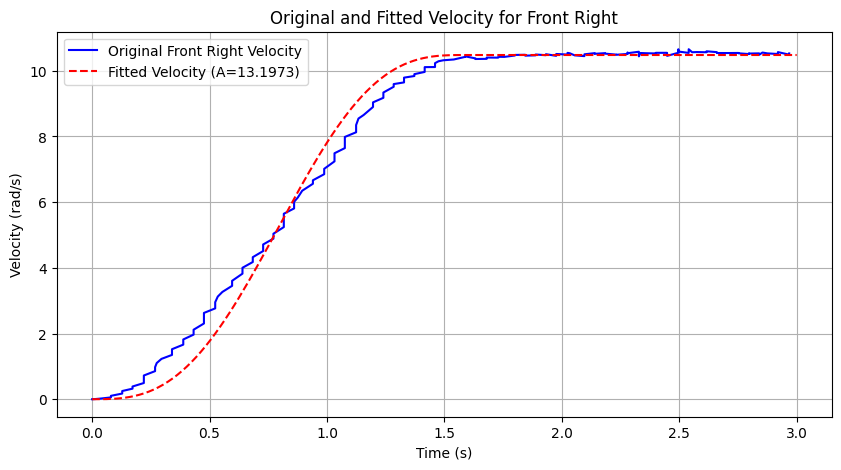

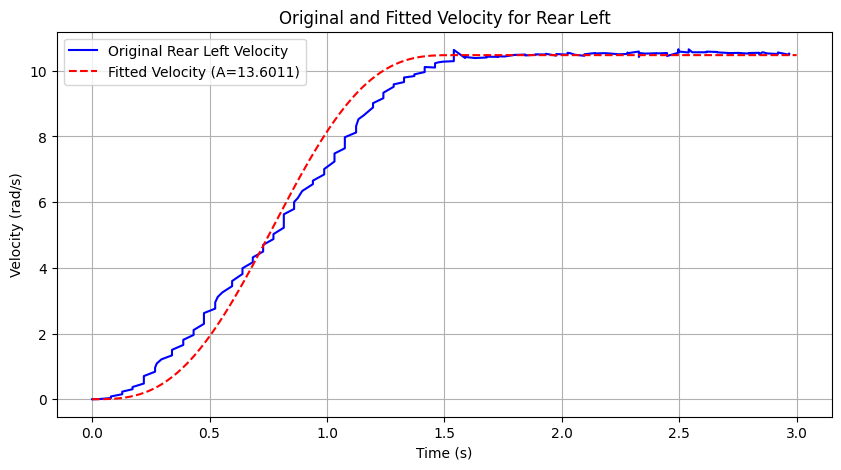

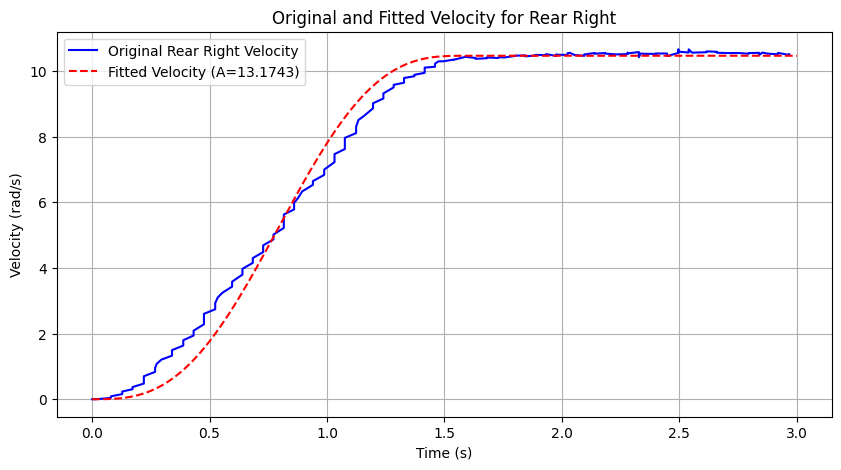

In [1]:
import os
import pandas as pd
import numpy as np
import random
from scipy.signal import convolve
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

threshold = 0.99


# Directory containing the processed data folders
input_directory = "../../../trajectory_data/real/recordings/x"

# Collect all CSV file paths from "wheel_velocities" folders
csv_files = []
for root, dirs, files in os.walk(input_directory):
    for dir_name in dirs:
        if dir_name == "wheel_velocities" and "complex_random_trajectory" not in root:
            folder_path = os.path.join(root, dir_name)
            for filename in os.listdir(folder_path):
                if filename.endswith(".csv"):
                    csv_files.append(os.path.join(folder_path, filename))

# Shuffle and split the CSV files into training and validation sets
random.shuffle(csv_files)
split_index = int(len(csv_files) * 0.7)
training_files = csv_files[:split_index]
validation_files = csv_files[split_index:]

def smooth_velocity(values_array, window_size):
    window = np.ones(window_size) / window_size
    smoothed_values = convolve(values_array, window, mode='same')
    return smoothed_values

# Function to define the velocity profile based on the parameter A
def velocity_profile(t, A, T_1, v_max):
    """Defines velocity profile where velocity remains constant after reaching v_max."""
    v_t = A * T_1 / (2 * np.pi) * (2 * np.pi * t / T_1 - np.sin(2 * np.pi * t / T_1))
    v_p = A * T_1 / (2 * np.pi) * (2 * np.pi * T_1 / T_1 - np.sin(2 * np.pi * T_1 / T_1))
    v_t = v_t/v_p * v_max
    # After T_1, velocity should stay constant at v_max
    v_t = np.where(t > T_1, v_max, v_t)
    return v_t

# Function to find the value of velocity closest to 3 seconds
def get_velocity_at_closest_time(time_array, velocity_array, target_time):
    closest_index = np.abs(time_array - target_time).argmin()
    return velocity_array[closest_index]

def fit_velocity_profile(times, velocities, v_max, t_f):
    # Initial guess for A based on v_max and t_f
    A_guess = (2 * v_max) / t_f
    
    # Fit the velocity profile to the data using curve fitting
    popt, _ = curve_fit(lambda t, A: velocity_profile(t, A, t_f, v_max), times, velocities, p0=[A_guess])
    
    # Extract the optimized value of A
    A_fitted = popt[0]
    return A_fitted

def plot_acceleration_and_fit_velocity(file_path, window_size):
    data = pd.read_csv(file_path)
    time = data['Time']
    wheels = data.columns[1:]

    for wheel in wheels:
        values_array = (data[wheel] - np.min(data[wheel]))

        adjusted_time = time - time.iloc[0]
        values_array = values_array[: len(adjusted_time)]

        # Smooth the velocity data
        smoothed_values = smooth_velocity(values_array, window_size)

        # Get v_max from the velocity closest to 3 seconds
        v_max = get_velocity_at_closest_time(adjusted_time, smoothed_values, 3.0)

        # Find the first time where the velocity reaches v_max
        v_max_index = np.where(smoothed_values >= v_max * threshold)[0][0]
        t_f = adjusted_time[v_max_index]  # Set t_f to this time

        cutoff = 3

        # Fit the velocity profile to the data
        A_fitted = fit_velocity_profile(adjusted_time[adjusted_time <= cutoff], smoothed_values[adjusted_time <= cutoff], v_max, t_f)

        # Generate time array for fitted velocity profile
        time_fitted = np.linspace(0, cutoff, len(adjusted_time[adjusted_time <= cutoff]))

        # Compute the fitted velocity profile
        fitted_velocity = velocity_profile(time_fitted, A_fitted, t_f, v_max)

        # Plot original velocity data and fitted velocity profile
        plt.figure(figsize=(10, 5))
        plt.plot(adjusted_time[adjusted_time <= cutoff], smoothed_values[adjusted_time <= cutoff], label=f'Original {wheel} Velocity', color='blue')
        plt.plot(time_fitted, fitted_velocity, label=f'Fitted Velocity (A={A_fitted:.4f})', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (rad/s)')
        plt.title(f'Original and Fitted Velocity for {wheel}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot velocity fits for the first 20 training files
for file_path in training_files[:20]:
    plot_acceleration_and_fit_velocity(file_path, 1)
